In [1]:
import os

# Use the current notebook directory as the root of the project
project_root = os.getcwd()
os.chdir(project_root)

print("Working directory set to:", os.getcwd())

Working directory set to: /Users/zhangjiuyue/jupternotebook/king's project


In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_rel
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [6]:
import os
from pydub import AudioSegment

# Path parameters
mp3_dir = "./data/whole/real music"
output_dir = "./data/stableaudio/real music"
output_dir = os.path.join("./outputs/")
os.makedirs(output_dir, exist_ok=True)

# Processing parameters
TARGET_LEN = 15 * 1000  # milliseconds, e.g. 15 seconds
TARGET_SR = 16000       # Sampling rate
TARGET_CHANNELS = 1     # Mono

for i in range(1, 6):
    mp3_path = os.path.join(mp3_dir, f"{i}.mp3")
    audio = AudioSegment.from_file(mp3_path)
    # Sample Rate, Mono
    audio = audio.set_frame_rate(TARGET_SR).set_channels(TARGET_CHANNELS)
    # Cut to specified length (make up mute if not enough)
    if len(audio) < TARGET_LEN:
        audio = audio + AudioSegment.silent(duration=TARGET_LEN - len(audio), frame_rate=TARGET_SR)
    audio = audio[:TARGET_LEN]
    # Export wav
    wav_path = os.path.join(output_dir, f"{i}.wav")
    audio.export(wav_path, format="wav")
    print(f"Saved: {wav_path}")

print("All processed and ready to be used for MCD analysis.")

Saved: ./outputs/1.wav
Saved: ./outputs/2.wav
Saved: ./outputs/3.wav
Saved: ./outputs/4.wav
Saved: ./outputs/5.wav
All processed and ready to be used for MCD analysis.


In [4]:
import os
import numpy as np
import librosa
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def load_mfcc(path, sr=16000, n_mfcc=13):
    y, _sr = librosa.load(path, sr=sr)
    print(f"Loaded {path}: y.shape={y.shape}, sr={_sr}")
    mfcc = librosa.feature.mfcc(y=y, sr=_sr, n_mfcc=n_mfcc)
    print(f"MFCC shape before T: {mfcc.shape}")
    mfcc = mfcc.T  # (T, n_mfcc)
    print(f"MFCC shape after T: {mfcc.shape}")
    return mfcc

def mcd(mfcc_ref, mfcc_gen):
    distance, path = fastdtw(mfcc_ref, mfcc_gen, dist=euclidean)
    print(f"[DEBUG] DTW path len={len(path)}, first 5: {path[:5]}")
    if not isinstance(path, list) or len(path) == 0:
        print("DTW failed, path invalid.")
        return np.nan
    # align and compute MCD on MFCC 1~12 (exclude 0-th)
    aligned_ref = np.array([mfcc_ref[i] for i, _ in path])
    aligned_gen = np.array([mfcc_gen[j] for _, j in path])
    diff = aligned_ref[:, 1:13] - aligned_gen[:, 1:13]
    dist = np.sqrt((diff ** 2).sum(axis=1))
    mcd_val = 10.0 / np.log(10) * np.mean(dist)
    print(f"[DEBUG] MCD value: {mcd_val:.2f}")
    return mcd_val

def batch_mcd(test_dir, ref_dir, n=5):
    mcds = []
    for i in range(1, n+1):
        ref_path = os.path.join(ref_dir, f"{i}.wav")
        test_path = os.path.join(test_dir, f"{i}.wav")
        print(f"\nProcessing {test_path} vs {ref_path}")
        try:
            mfcc_ref = load_mfcc(ref_path)
            mfcc_test = load_mfcc(test_path)
            print(f"MFCC_ref shape: {mfcc_ref.shape}, MFCC_test shape: {mfcc_test.shape}")
            val = mcd(mfcc_ref, mfcc_test)
            mcds.append(val)
            print(f"MCD {os.path.basename(test_dir)} #{i}: {val:.2f}")
        except Exception as e:
            print(f"Error at #{i}: {e}")
            mcds.append(np.nan)
    return mcds

# 路径按你最新的实际情况填写
real_dir = "./data/stableaudio/real music"
original_dir = "./data/stableaudio/original"
epoch12_dir = "./data/stableaudio/epoch12"
epoch99_dir = "./data/stableaudio/epoch99"

# 批量计算
mcd_original = batch_mcd(original_dir, real_dir)
mcd_epoch12 = batch_mcd(epoch12_dir, real_dir)
mcd_epoch99 = batch_mcd(epoch99_dir, real_dir)

print("MCDs (original):", mcd_original)
print("MCDs (epoch12):", mcd_epoch12)
print("MCDs (epoch99):", mcd_epoch99)


Processing ./data/stableaudio/original/1.wav vs ./data/stableaudio/real music/1.wav
Loaded ./data/stableaudio/real music/1.wav: y.shape=(240000,), sr=16000
MFCC shape before T: (13, 469)
MFCC shape after T: (469, 13)
Loaded ./data/stableaudio/original/1.wav: y.shape=(190218,), sr=16000
MFCC shape before T: (13, 372)
MFCC shape after T: (372, 13)
MFCC_ref shape: (469, 13), MFCC_test shape: (372, 13)
[DEBUG] DTW path len=471, first 5: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0)]
[DEBUG] MCD value: 632.91
MCD original #1: 632.91

Processing ./data/stableaudio/original/2.wav vs ./data/stableaudio/real music/2.wav
Loaded ./data/stableaudio/real music/2.wav: y.shape=(240000,), sr=16000
MFCC shape before T: (13, 469)
MFCC shape after T: (469, 13)
Loaded ./data/stableaudio/original/2.wav: y.shape=(190218,), sr=16000
MFCC shape before T: (13, 372)
MFCC shape after T: (372, 13)
MFCC_ref shape: (469, 13), MFCC_test shape: (372, 13)
[DEBUG] DTW path len=473, first 5: [(0, 0), (1, 1), (2, 2), (3, 3), 

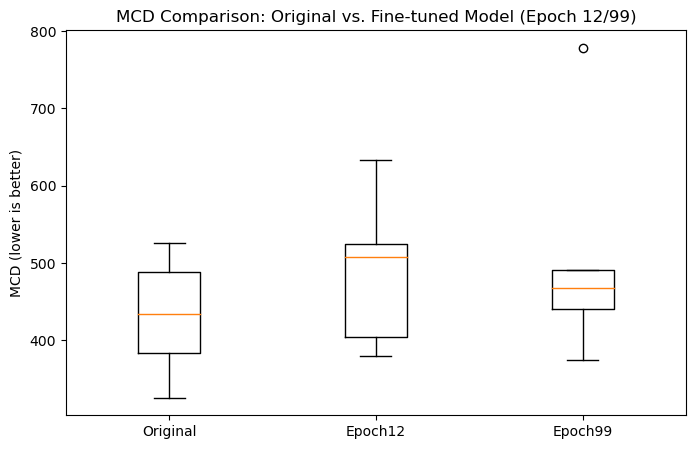

In [7]:
import matplotlib.pyplot as plt

data = {
    "Original": [488.07, 383.55, 434.83, 526.28, 325.87],
    "Epoch12":  [632.91, 404.67, 524.98, 508.29, 379.51],
    "Epoch99":  [778.40, 440.11, 467.60, 490.91, 374.73]
}

plt.figure(figsize=(8, 5))
plt.boxplot(data.values(), labels=data.keys())
plt.ylabel("MCD (lower is better)")
plt.title("MCD Comparison: Original vs. Fine-tuned Model (Epoch 12/99)")
plt.savefig(os.path.join(output_dir, "Fine_Tune.png"), dpi=300)
plt.show()

/var/folders/3g/7jssd8xj3fn77vc3gqfm7x9c0000gn/T/ipykernel_46418/504445588.py:13: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00018311 -0.0055542
 -0.01400757] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=sr, n_mels=80, fmax=8000)
/var/folders/3g/7jssd8xj3fn77vc3gqfm7x9c0000gn/T/ipykernel_46418/504445588.py:13: FutureWarning: Pass y=[-1.37050671e-03 -7.31766340e-04 -3.44418501e-03 ... -1.32629875e-05
 -1.91283580e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=sr, n_mels=80, fmax=8000)
/var/folders/3g/7jssd8xj3fn77vc3gqfm7x9c0000gn/T/ipykernel_46418/504445588.py:13: FutureWarning: Pass y=[ 3.7625464e-04  9.9593191e-04  3.7846738e-04 ... -1.7074744e-06
  4.0023556e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will 

IndexError: list index out of range

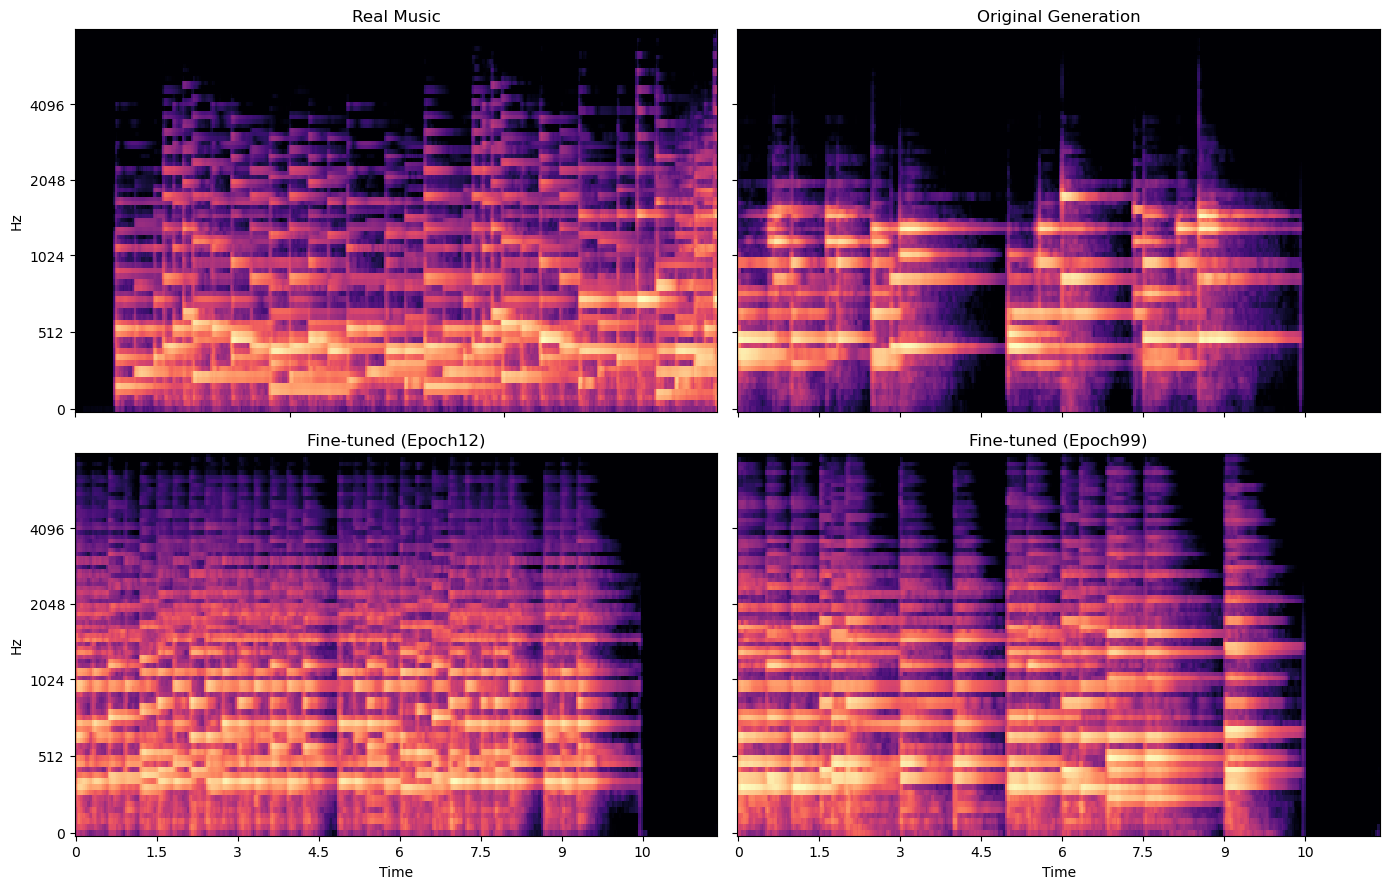

In [10]:
# 选择你要展示的样本编号（1~5）
sample_idx = 3  # 例：展示第3个

# 自动拼接路径
real_path = os.path.join(real_dir, f"{sample_idx}.wav")
orig_path = os.path.join(original_dir, f"{sample_idx}.wav")
ep12_path = os.path.join(epoch12_dir, f"{sample_idx}.wav")
ep99_path = os.path.join(epoch99_dir, f"{sample_idx}.wav")

# 画图函数
def plot_melspec(audio_path, ax, title):
    y, sr = librosa.load(audio_path, sr=16000)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=80, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=ax, fmax=8000, cmap='magma')
    ax.set_title(title)
    ax.label_outer()
    return img

# 绘制 2x2 热力图
fig, axs = plt.subplots(2, 2, figsize=(14, 9))
axs = axs.flatten()

titles = [
    "Real Music",
    "Original Generation",
    "Fine-tuned (Epoch12)",
    "Fine-tuned (Epoch99)"
]
paths = [real_path, orig_path, ep12_path, ep99_path]

for ax, path, title in zip(axs, paths, titles):
    plot_melspec(path, ax, title)

plt.tight_layout()
plt.colorbar(axs[3].images[0], ax=axs, orientation='vertical', fraction=0.015)
plt.suptitle(f"Mel-spectrogram Comparison for Sample {sample_idx}", y=1.02, fontsize=16)
plt.show()